# Using GalFlow to perform FFT-based convolutions

In [2]:
import tensorflow as tf
import galflow as gf
import galsim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# First let's draw a galaxy image with GalSim
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
cat = galsim.COSMOSCatalog(dir=data_dir)

psf = cat.makeGalaxy(2,  gal_type='real', noise_pad_size=0).original_psf
gal = cat.makeGalaxy(2,  gal_type='real', noise_pad_size=0)
conv = galsim.Convolve(psf, gal)

In [4]:
# We draw the galaxy on a postage stamp
imgal = gal.drawImage(nx=128, ny=128, scale=0.03,
                      method='no_pixel',use_true_center=False)

imconv = conv.drawImage(nx=128, ny=128, scale=0.03, 
                        method='no_pixel', use_true_center=False)

# We draw the PSF image in Kspace at the correct resolution
N = 128
im_scale = 0.03
interp_factor=2
padding_factor=2
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI
bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)

impsf = psf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)


imkgal = gal.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


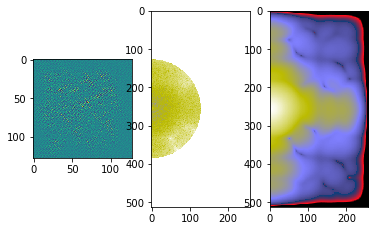

In [5]:
subplot(131)
imshow(imgal.array)
subplot(132)
imshow(log10(abs(imkgal.array)), cmap='gist_stern', vmin=-8)
subplot(133)
imshow(log10(abs(impsf.array)), cmap='gist_stern', vmin=-8)

In [6]:
ims = tf.placeholder(shape=[1, N, N, 1], dtype=tf.float32)
kims = tf.placeholder(shape=[1, Nk, Nk//2+1], dtype=tf.complex64)
kpsf = tf.placeholder(shape=[1, Nk, Nk//2+1], dtype=tf.complex64)

res = gf.convolve(ims, kpsf,
                  zero_padding_factor=padding_factor,
                  interp_factor=interp_factor )

resk = gf.kconvolve(kims, kpsf,
                   zero_padding_factor=padding_factor,
                   interp_factor=interp_factor )

In [7]:
with tf.Session() as sess:
    conv, convk = sess.run([res, resk], 
                           feed_dict={ims:imgal.array.reshape(1,N,N,1),
                                      kpsf:fftshift((impsf.array).reshape(1,Nk,Nk//2+1), axes=1),
                                      kims:fftshift((imkgal.array).reshape(1,Nk,Nk//2+1), axes=1)
                                      })

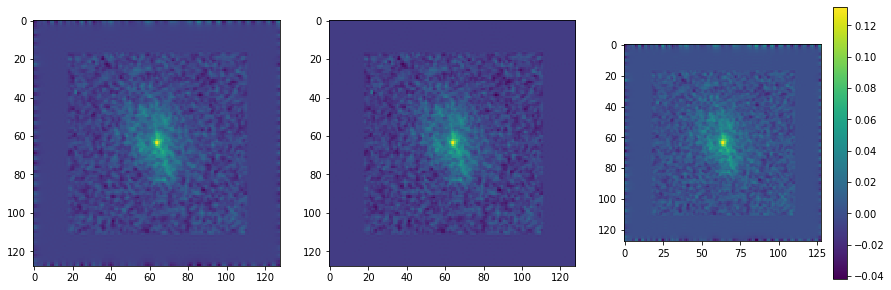

In [8]:
figure(figsize=(15,5))
subplot(131)
imshow((conv[0,:,:,0]))
subplot(132)
imshow(imconv.array)
subplot(133)
imshow(((conv[0,:,:,0] -imconv.array)));colorbar()

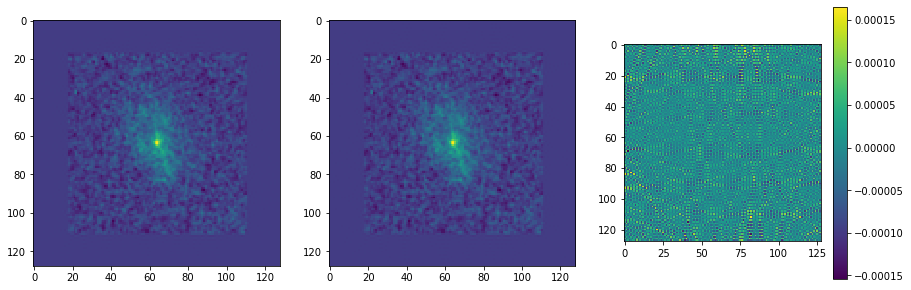

In [9]:
figure(figsize=(15,5))
subplot(131)
imshow(fftshift(convk[0,:,:,0])[64:-64,64:-64])
subplot(132)
imshow(imconv.array)
subplot(133)
imshow(((fftshift(convk[0,:,:,0])[64:-64,64:-64] -imconv.array)));colorbar()

## Testing k-space convolution with custom window function

Here we experiment with reconvolving the images at a different resolution using a band limited effective psf, in this case a Hanning window

In [10]:
from scipy.signal.windows import hann

In [11]:
# We draw the PSF image in Kspace at the correct resolution
N = 64
im_scale = 0.168
interp_factor=3
padding_factor=2
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI
bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)

In [12]:
# Hann window
stamp_size = Nk
target_pixel_scale=im_scale
pixel_scale=im_scale/interp_factor
my_psf = np.zeros((stamp_size,stamp_size))
for  i in range(stamp_size):
    for j in range(stamp_size):
        r = sqrt((i - 1.0*stamp_size//2)**2 + (j-1.0*stamp_size//2)**2)/(stamp_size//2)*pi/2*target_pixel_scale/pixel_scale
        my_psf[i,j] = sin(r+pi/2)**2
        if r >= pi/2:
            my_psf[i,j] = 0

my_psf = fftshift(my_psf)[:, :stamp_size//2+1]   
effective_psf = galsim.ImageCF(my_psf,bounds=bounds,
                            scale=2.*np.pi/(N* im_scale))

In [13]:
ims = tf.placeholder(shape=[1, N, N, 1], dtype=tf.float32)
kims = tf.placeholder(shape=[1, Nk, Nk//2+1], dtype=tf.complex64)
kpsf = tf.placeholder(shape=[1, Nk, Nk//2+1], dtype=tf.complex64)

res = gf.convolve(ims, kpsf,
                  zero_padding_factor=padding_factor,
                  interp_factor=interp_factor )

resk = gf.kconvolve(kims, kpsf,
                   zero_padding_factor=padding_factor,
                   interp_factor=interp_factor )

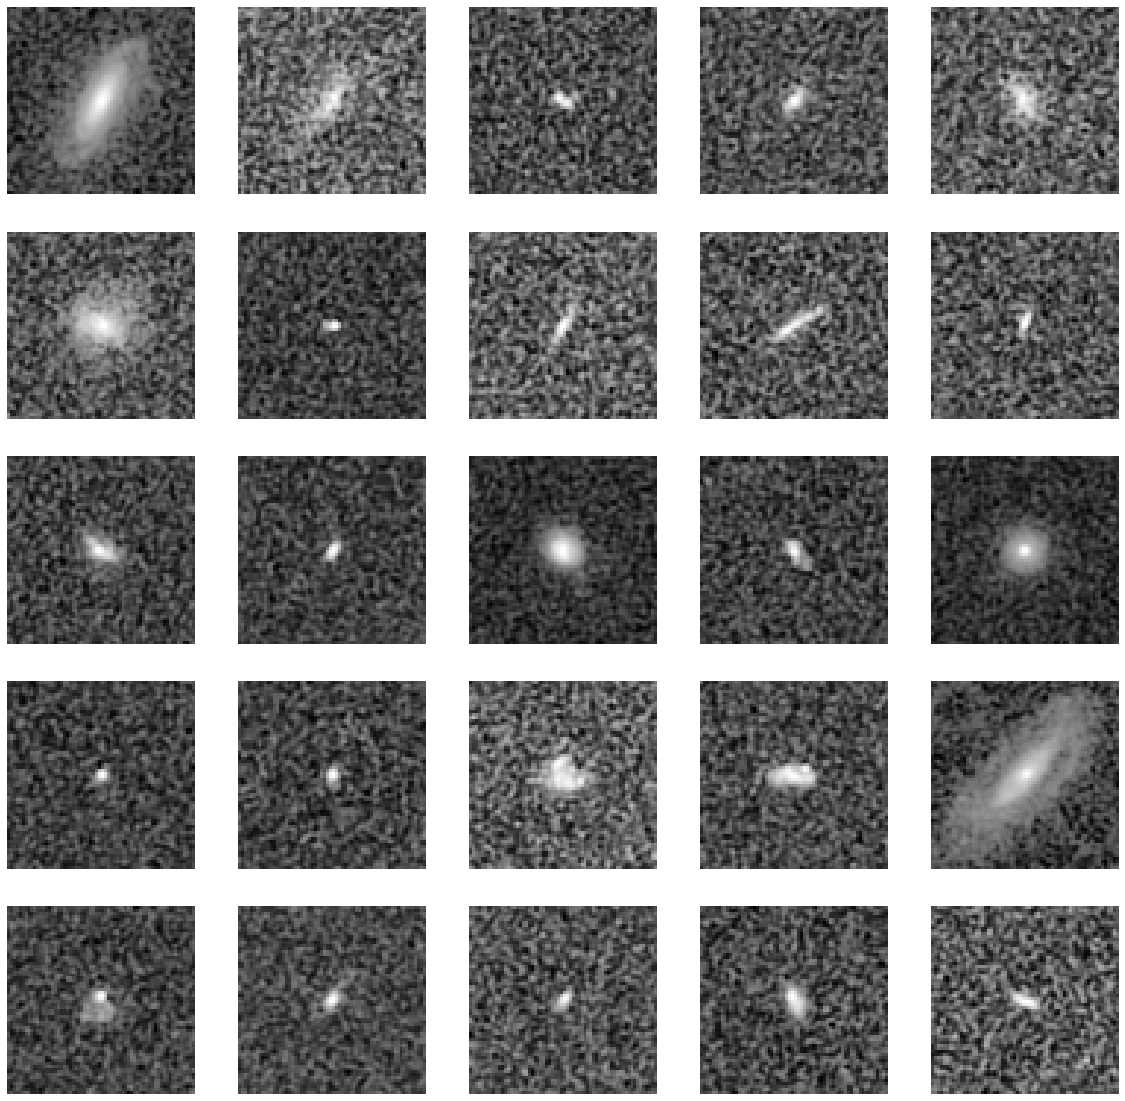

In [14]:
figure(figsize=(20,20))
c=0
sess = tf.Session()
for i in range(25):
    gal = cat.makeGalaxy(9+i, noise_pad_size=im_scale*N/2*1.25)
    imkgal = gal.drawKImage(bounds=bounds,
                            scale=2.*np.pi/(N* im_scale),
                            recenter=False)
    
    yop = sess.run(resk, feed_dict={kpsf:my_psf.reshape(1,Nk,Nk//2+1),
                                    kims:fftshift((imkgal.array).reshape(1,Nk,Nk//2+1), axes=1)
                                    })
    subplot(5,5,c+1)
    imshow(arcsinh(50*fftshift(yop[0,:,:,0]))[N//2:-N//2,N//2:-N//2],cmap='gray')
    axis('off')
    c+=1

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0.5, 1.0, 'Output image')

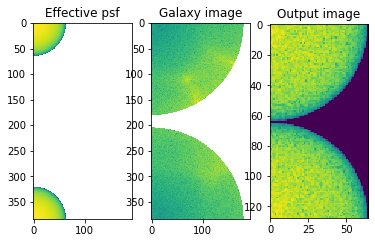

In [15]:
subplot(131)
imshow(log10(my_psf));
title('Effective psf')
subplot(132)
imshow(log10(abs(fftshift((imkgal.array).reshape(1,Nk,Nk//2+1), axes=1)))[0],vmin=-5)
title('Galaxy image')
subplot(133)
imshow(log10(abs(rfft2(yop[0,:,:,0]))),vmin=-5)
title('Output image')